# __Scenario C:__<br>SLAC characterization

Data provided by Alaric Prins (Biocatalysis and Technical Biology, Cape Peninsula University of Technology, Capetown, South Africa)

## Project background
In this scenario, the catalytic properties of the small laccase from *Streptomyces coelicolor* (SLAC) were investigated. Therefore, the enzymatic oxidation of 2,2'-Azino-bis(3-ethylbenzothiazoline-6-sulfonic acid) (ABTS) to its radical form ABTS<sup>+·</sup> was studied in the pH range between pH 3&nbsp;-&nbsp;5.5 and temperature range between 25°C&nbsp;-&nbsp;45°C. In total 30 kinetic enzyme assays in a substrate range between 0&nbsp;-&nbsp;200&nbsp;uM of ABTS were conducted. For each pH - temperature condition a seperate ABTS standard curve and absorption spectrum was recorded, in order to account for absorbance changes do to reaction conditions. Each enzyme reaction was followed for 15 min photometrically at two seperate wavelengths, measuring substrate depletion and product accumululation simultaneously. Therefore, preliminary experiments confirmed, that ABTS absorbs at 340 nm, whereas the ABTS<sup>+·</sup> radical product absorbs at 420 nm, which is in accordance with literature {cite:p}`wang2019multi`
Overall, the dataset consists of more than 100&nbsp;000 individual absorbance reads. Thus, data preperation was automated by custom parser functions, which were tailored for the output of the used spectro photometer. Consequently, the tedious and error-prone manual copying of raw data was automated. Information on the involved reactants, and the enzyme was filled in an EnzymeML Excel spreadsheet, which served as a meta data container.


All data except for measurement data was entered into an EnzymeML Excel-template. Therein, concentration information of the enzyme and initial substrate was specified. All other information was parsed from the .txt output of the photometer.

## Experimental design

### Wet lab
- Dual wavelength
- control reactions

### Data management
![Fig33](../images/workflow_SLAC.png)
_Fig. 22: Schematic workflow of the SLAC characterization data flow._

pipapapo.

## Data preparation

### Imports

In [33]:
from typing import Dict, List
import pyenzyme as pe
import numpy as np
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from lmfit import Parameters, minimize
from scipy.stats import linregress, pearsonr
from joblib import Parallel, delayed
from CaliPytion.tools.standardcurve import StandardCurve
from EnzymePynetics.tools.parameterestimator import ParameterEstimator

# Custom functions for data mapping
from parser_functions import measurement_data_to_EnzymeML, plot
from parser_functions import read_measurement_data, read_calibration_data

import warnings
warnings.filterwarnings('ignore')

### Experimantal data

Data from the enzyme reactions was loaded from the output files of the photometer and written to individual EnzymeML documents.


All experiments contain a control reaction without substrate. The control reaction is used in the next cell to subtract the absorption, contributed from enzyme and buffer. After blanking, the control measurement is deleted from the dataset.

In [4]:
# Specify the location of the data sets
directory_measurement_data = "../../data/SLAC_kinetic_characterization/TimeCourseData"
directory_standard_data = "../../data/SLAC_kinetic_characterization/StandardData"
directory_spectrum_data = "../../data/SLAC_kinetic_characterization/SpectrumData"
path_EnzymeML_templates = "../../data/SLAC_kinetic_characterization/EnzymeML_templates"

# Define IDs for species, listed in the EnzymeML Excel template
substrate_id = "s0"
product_id = "s1"
substrate_control_id = "s2"
product_control_id = "s3"
species_ids = [substrate_id, product_id, substrate_control_id, product_control_id]


# Parse measurement data from photometer output
raw_data_dict = {}
for path in os.listdir(directory_measurement_data):
    data = read_measurement_data(f"{directory_measurement_data}/{path}")
    pH = data["pH"]
    temp = data["temperature"]
    raw_data_dict[f"{pH} {temp}"] = data

EnzymeML_template_dict = {
    3.0: "EnzymeML_SLAC_pH3.xlsm",
    3.5: "EnzymeML_SLAC_pH3_5.xlsm",
    4.0: "EnzymeML_SLAC_pH4.xlsm",
    4.5: "EnzymeML_SLAC_pH4_5.xlsm",
    5.0: "EnzymeML_SLAC_pH5.xlsm",
    5.5: "EnzymeML_SLAC_pH5_5.xlsm",
}

# Write absorption data to EnzymeMLDocuments
absortion_enzymemldocs: List[pe.EnzymeMLDocument] = []
for name, data in raw_data_dict.items():
    pH = data["pH"]
    absortion_enzymemldocs.append(measurement_data_to_EnzymeML(
        template_path=f"{path_EnzymeML_templates}/{EnzymeML_template_dict[pH]}",
        measurement_data=data,
        species_ids=species_ids,
        data_unit="umole / l",
        time_unit="s"))

# Sort documents by ascending pH and temperature
absortion_enzymemldocs = sorted(absortion_enzymemldocs, key=lambda x: (x.getReaction("r0").ph, x.getReaction("r0").temperature))

# Blanc measurement data
for enzmldoc in absortion_enzymemldocs:
    blanc_measurement = enzmldoc.measurement_dict["m0"].getReactant("s0").replicates
    blanc = np.mean([repeat.data for repeat in blanc_measurement])

    for id, measurement in enzmldoc.measurement_dict.items():
        for rep, replicate in enumerate(measurement.getReactant("s0").replicates):
            blanced_data = [value - blanc for value in replicate.data]
            enzmldoc.measurement_dict[id].getReactant("s0").replicates[rep].data = blanced_data
        for rep, replicate in enumerate(measurement.getReactant("s2").replicates):
            blanced_data = [value - blanc for value in replicate.data]
            enzmldoc.measurement_dict[id].getReactant("s2").replicates[rep].data = blanced_data

        for rep, replicate in enumerate(measurement.getReactant("s1").replicates):
            blanced_data = [value - blanc for value in replicate.data]
            enzmldoc.measurement_dict[id].getReactant("s1").replicates[rep].data = blanced_data
        for rep, replicate in enumerate(measurement.getReactant("s3").replicates):
            blanced_data = [value - blanc for value in replicate.data]
            enzmldoc.measurement_dict[id].getReactant("s3").replicates[rep].data = blanced_data
    
    # Delete control measurement 'm0'
    del enzmldoc.measurement_dict["m0"]

### Concentration calculation

Nextup, calibration data was loaded and converted into individual instances of the calibration data model. Some meta data of the calibration needs to be provided to the custom ```read_calibration_data``` function, since the output of the used spectro photometer only contains a minimum of information. Thereafter, a ```StandardCurve``` is created for each calibration data set. Thereby, only absoption values below 3 are considered, since higher absorption values cannot be converted into concentration accurately. 
Lastly, the fit of each standard curves is visualized.

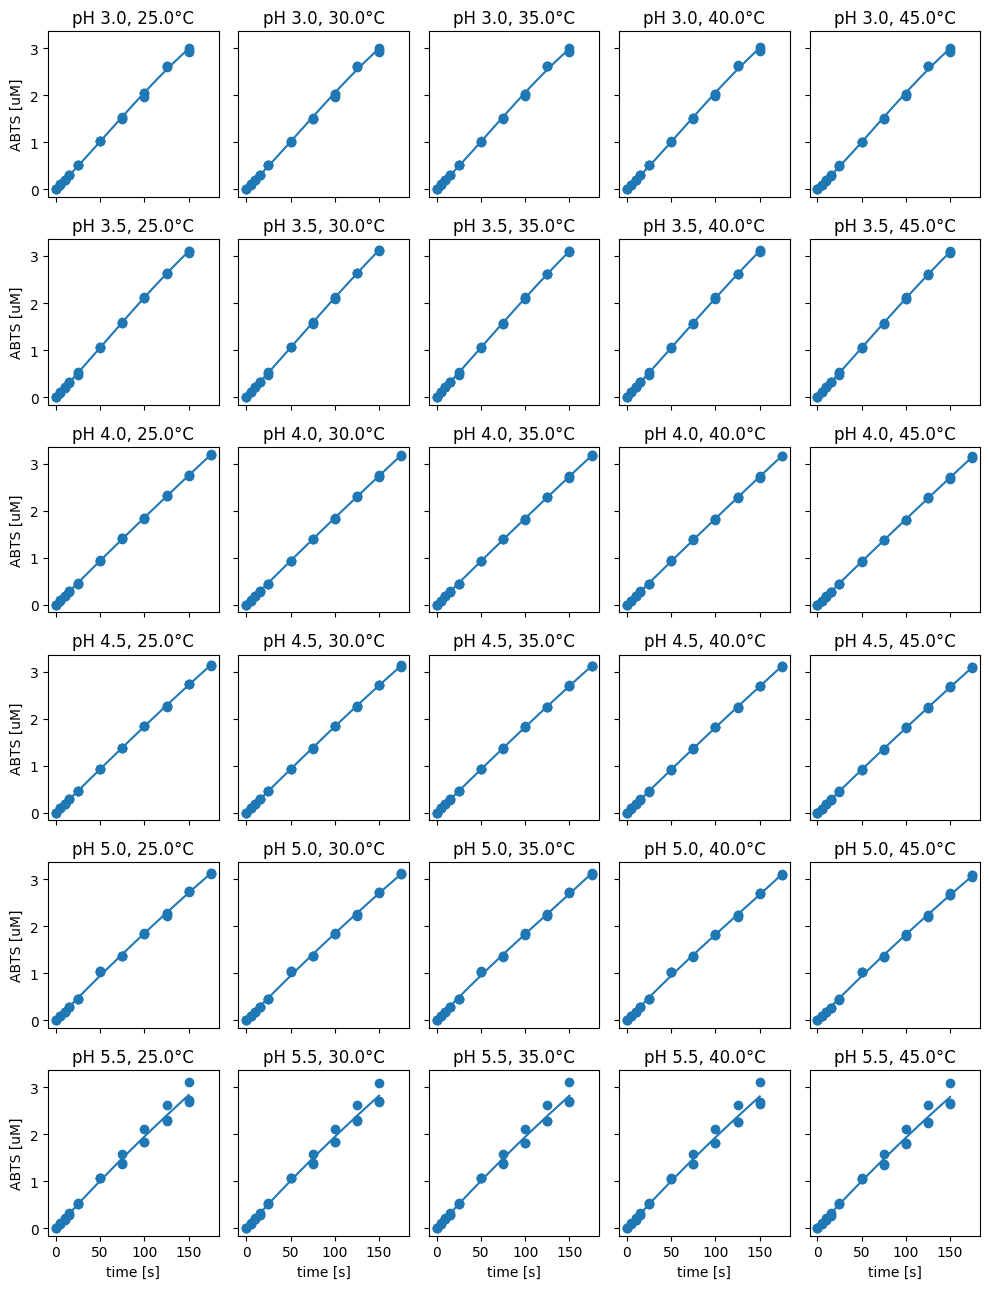

In [6]:
# Load calibration raw data
calibration_data = []
standard_directory = np.sort(os.listdir(directory_standard_data))
spectrum_directory = np.sort(os.listdir(directory_spectrum_data))

for standard, spectrum in zip(standard_directory, spectrum_directory):
    standard = f"{directory_standard_data}/{standard}"
    spectrum = f"{directory_spectrum_data}/{spectrum}"
    result = read_calibration_data(
        path_standard=standard,
        path_spectrum=spectrum,
        species_id=substrate_id,
        wavelengths=[340, 420],
        concentrations=[0,5,10,15,25,50,75,100,125,150,175,200],
        concentration_unit="umole / l",
        device_manufacturer="MANUFACTURER",
        device_model="SUPERMODEL",
        spectrum_reactant_concentration=69
    )
    for pH in result.keys():
        calibration_data.append(result[pH])

# Sort calibration data by ascending pH and temperature
calibration_data = sorted(calibration_data, key = lambda x: (x.pH, x.temperature))

# Generate standard curves for ABTS calibration data
standard_curves: List[StandardCurve] = []
for calibration in list(calibration_data):
    standard_curves.append(StandardCurve(calibration_data=calibration, wavelength=340, cutoff_absorption=3.2, show_output=False))

# Sort standard curves by ascending pH and temperature.
standard_curves = sorted(standard_curves, key = lambda x: (x.calibration_data.pH, x.calibration_data.temperature))

# Visualize all fitted standard curves 
fig, axes = plt.subplots(6,5, figsize=(10, 13), sharey=True, sharex=True)
for i, (standard, ax) in enumerate(zip(standard_curves[:30], axes.flatten())):
    if not i%5:
        ax.set_ylabel("ABTS [uM]")
    standard.visualize(ax=ax)
    ax.set_title(f"pH {standard.calibration_data.pH}, {standard.calibration_data.temperature}°C")
    if i in [25,26,27,28,29]:
        ax.set_xlabel("time [s]")
plt.tight_layout()

The figure above shows the standard curves for all experimental conditions of this scenario. Since the absorption proterties ABTS change with pH, the calibration range differs between some pH values, due to the upper absorption limit. In consequence, the upper calibration limit for reactions at pH 3, pH 3.5, and pH 5.5 is at 150 uM of ABTS, whereas for all other pH values the upper limit is at 175 uM. The sulfonate groups of ABTS are deprotonated for more neutral pH values. Therefore, the absorption properties of ABTS might decrease. Calibration curve data at pH 5.5 shows larger variation between the repeats. In this case, pipetting of one of the the three repeats differs from the other two, which should be considered for kinetic parameter estimation. In contrast to pH, the temperature during calibration affected the calibration curve only marginally.  

Nextup, the generate standard curves were used to convert the absorption measurement data into concentration data. Thereby, the respective concentration values were only calculated, if the measured absorption was within the respective calibration bounds

In [25]:
# Calculate concentrations by applying standard curves to 'EnzymeMLDocuments'.
concentration_enzymemldocs = []
for standard_curve, abso_enzmldoc in zip(standard_curves, absortion_enzymemldocs):

    # Validate, that measurement data is paired with respective standard curve
    assert standard_curve.calibration_data.pH == abso_enzmldoc.getReaction("r0").ph
    assert standard_curve.calibration_data.temperature == abso_enzmldoc.getReaction("r0").temperature

    enzmldoc = copy.deepcopy(abso_enzmldoc)
    conc_enzmldoc = standard_curve.apply_to_EnzymeML(enzmldoc, "s0", ommit_nan_measurements=True)
    conc_enzmldoc = standard_curve.apply_to_EnzymeML(enzmldoc, "s2", ommit_nan_measurements=True)

    concentration_enzymemldocs.append(conc_enzmldoc)

Measurements '['m9']' removed from document, since respective measurement values are out of calibration range.
Measurements '['m9']' removed from document, since respective measurement values are out of calibration range.
Measurements '['m9']' removed from document, since respective measurement values are out of calibration range.
Measurements '['m9']' removed from document, since respective measurement values are out of calibration range.
Measurements '['m9']' removed from document, since respective measurement values are out of calibration range.
Measurements '['m9']' removed from document, since respective measurement values are out of calibration range.
Measurements '['m9']' removed from document, since respective measurement values are out of calibration range.
Measurements '['m9']' removed from document, since respective measurement values are out of calibration range.
Measurements '['m8']' removed from document, since respective measurement values are out of calibration range.
M

## Quality control through mass balance analysis

Since product and substrate of the SLAC reaction were simultaneously recorded, mass balance analysis was conductas as a control of quality. By assuming mass conservation, the following concentration balance can be established:  
```{math}
:label: mass_balance
0 = S_{(t)} + P_{(t)} - S_{0}
```
Thereby, $S_{0}$ denotes the initial substrate concentration, whereas $S_{(t)}$ and $P_{(t)}$ describe the substrate and product concentration for each time point $t$. $S_{t}$ and $S_{0}$ were individually measured. Thus each enzyme reaction with a given initial substrate concentration had a control reaction with identical substrate concentration. In contrast to the substrate, no calibration standard is available for the product. Therefore, an additional parameter §k§ was introdiced to the mass balance equation, assuming linear relationship between the product concentration and its signal:  

```{math}
:label: mass_balance_with_k
0 = S_{(t)} + P_{(t)}k - S_{0}
```

$k$ was determined for each data set individually by a minimization algorithm. The minimization objective was to find the optimal $k$, which minimizes all slopes of a given reaction condition. Thereafter, the mass balances of all measurements were visualized.


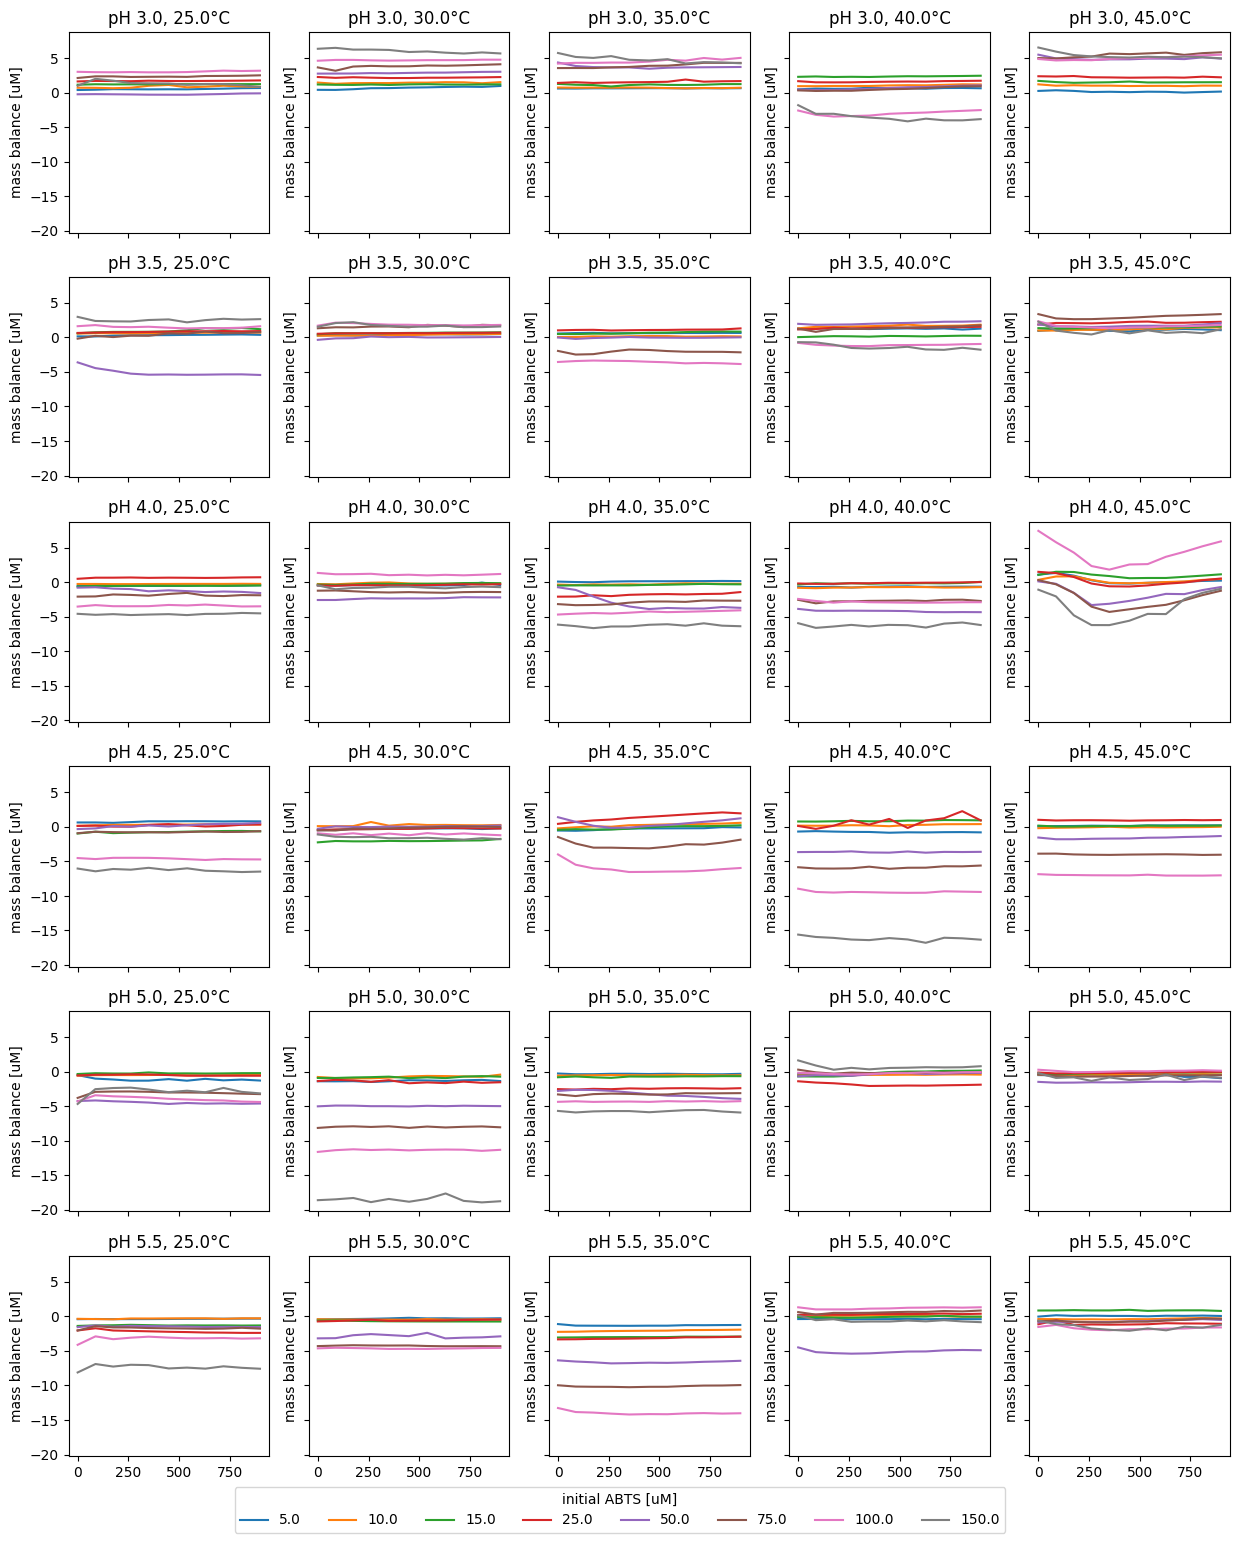

In [8]:
# Defenition of parameter 'k'
params = Parameters()
params.add("k", value=30, min=0, max=200)

# Target function for the minimizer
def residual(params, x):
    k=params["k"]

    substrate, product,  control = x
    slopes = substrate[:,0] * 0.0
    for i, (s, p, c) in enumerate(zip(substrate, product, control)):
        sub = np.mean(s, axis=0)
        prod = np.mean(p, axis=0)
        cont = np.mean(c, axis=0)

        model = sub + prod*k - cont

        slopes[i] = linregress(np.arange(len(model)), model)[0]

    return slopes.flatten()


f = []
fig, axes = plt.subplots(6,5, figsize=(12.5, 15), sharey=True, sharex=True)
for e, (doc, ax) in enumerate(zip(concentration_enzymemldocs, axes.flatten())):
    substrate = []
    product = []
    initial_substrate = []
    control = []
    for measurement in doc.measurement_dict.values():
        initial_substrate.append(measurement.getReactant(substrate_id).init_conc)
        for replicate in measurement.getReactant(substrate_id).replicates:
            substrate.append(replicate.data)
        for replicate in measurement.getReactant(product_id).replicates:
            product.append(replicate.data)
        for replicate in measurement.getReactant("s2").replicates:
            control.append(replicate.data)

    time = np.array(replicate.time)

    product = np.array(product).reshape(int(len((product))/3),3,11)
    substrate = np.array(substrate).reshape(int(len((substrate))/3),3,11)
    control = np.array(control).reshape(int(len((control))/3),3,11)
    initial_substrate = np.array(initial_substrate)

    x = (substrate, product, control)

    result = minimize(residual, params, args=(x,))

    factor = result.params["k"].value
    f.append(factor)

    for i, (s, p, c, l) in enumerate(zip(substrate, product,  control, initial_substrate)):
        init = np.mean(c, axis=0)
        sub = np.mean(s, axis=0)
        prod = np.mean(p, axis=0)
        cont = np.mean(c, axis=0)
        balance = (sub + prod*factor - cont)

        ax.plot(doc.getMeasurement("m1").getReactant("s0").replicates[0].time, balance, label = l)
        if not i%5:
            ax.set_ylabel("mass balance [uM]")
        if i in [24, 25, 26, 27, 28, 29]:
            ax.set_xlabel("time [s]")
        pH = doc.getReaction("r0").ph
        temp = doc.getReaction("r0").temperature
        ax.set_title(f"pH {pH}, {temp}°C")#, factor: {factor:.0f}")
    if e == 0:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc="lower center", ncol=len(labels), title="initial ABTS [uM]", bbox_to_anchor=(0.5,-0.03))
plt.tight_layout()



The figure above shows the mass balances for all experiments. For all reactions, except for pH 4, 45°C and pH 4.5, 35°C, the product and substrate is in balance over the reaction time-course. Mass balances, diverging from 0 uM indicate, result likely from pipetting errors, eighter increasing or decreasing the substrate concentration in the enzyme- or control reaction. In the reactions at pH 4, 45°C and pH 4.5, 35°C the mass balance slopes are not linear. This indicates issues with the measurement, presumably from the spectro photometer. Therefore, the respective measurements might result in wrong parameter estimations.

## Kinetic parameter estimantion

### Model choice

Model selection is vital for parameter estimation. Thus, different settings for the parameter estimator were tested. Firstly, substrate and product inhibition models were excluded, since in some of the experiments the actual initial substrate concentration was higher than the specified initial substrate concentration. This results calculated product concentrations with negative value. Hence, product inhibition models were excluede, since no acurate information on product concentration was available.  
Secondly, substrate inhibition models were excluded, since the model was not able to describe the observed reaction kinetics. This was evident from a higher Akaike information criterion as well as more than 100 % standard deviation on the estimated parameters.  
Lastly, the irreversible Michaelis-Menten model with and without time-dependent enzyme inactivation was compared, since enzyme inactivation was observed in previous experiments. Estimated parameters and the fitted models are shown for the experimental data at pH 3 and 25°C. Once without enzyme inactivation and once with.

Estimated parameters without time-dependent enzyme inactivation:
Fitting data to:
 - irreversible Michaelis Menten model


,AIC,Km [umole / l],kcat / Km [1/s * 1/umole / l],kcat [1/s]
irreversible Michaelis Menten,-162,35.473 +/- 5.52%,0.009 +/- 5.89%,0.308 +/- 2.07%




Estimated parameters with time-dependent enzyme inactivation:
Fitting data to:
 - irreversible Michaelis Menten model


,AIC,Km [umole / l],kcat / Km [1/s * 1/umole / l],kcat [1/s],ki time-dep enzyme-inactiv. [1/s]
irreversible Michaelis Menten,-476,35.137 +/- 3.00%,0.013 +/- 3.58%,0.460 +/- 1.95%,0.001 +/- 4.47%


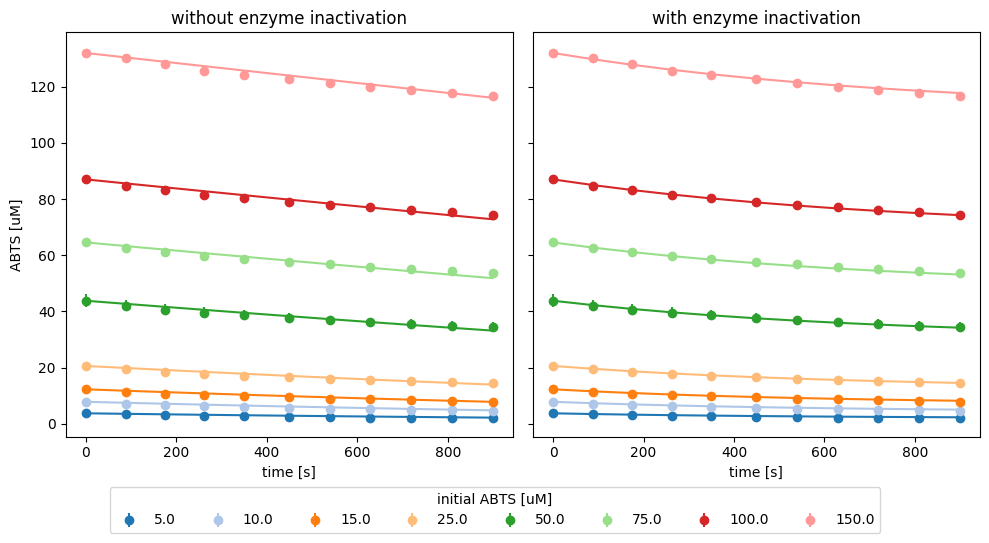

In [9]:
fig, axes = plt.subplots(1,2, figsize=(10,5), sharey=True, sharex=True)
for i, ax in enumerate(axes.flatten()):
    if i == 0:
        print("Estimated parameters without time-dependent enzyme inactivation:")
        kinetics = ParameterEstimator.from_EnzymeML(concentration_enzymemldocs[0], "s0", "substrate")
        kinetics.fit_models(only_irrev_MM=True)
        kinetics.visualize(ax=ax, title="without enzyme inactivation")
        ax.set_ylabel("ABTS [uM]")
        print("\n")
    else:
        print("Estimated parameters with time-dependent enzyme inactivation:")
        kinetics = ParameterEstimator.from_EnzymeML(concentration_enzymemldocs[0], "s0", "substrate")
        kinetics.fit_models(enzyme_inactivation=True, only_irrev_MM=True)
        kinetics.visualize(ax=ax, title="with enzyme inactivation")
    ax.set_xlabel("time [s]")
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=len(labels), title="initial ABTS [uM]", bbox_to_anchor=(0.5,-0.09))
plt.tight_layout()

Both plots in the above figure contain the same experimental data. The left plot shows the fitted model with enzyme inactivation and the right without enzyme inactivation, which is shown as solid lines. Visually, the model with enzyme inactinvation describes the data better, since the model intersects the data points more directly, compared to the model without enzyme inactivation. Statistically, this is characterized through a lower Akaike information criterion, as well as lower standard deviations on the estimated parameters. 
In absolute therms, the estimated $K_{m}$ of both models is approximately identical, whereas the $k_{cat}$ estimate is approximately 33% lower for the model without enzyme inactivation. Hence, the model without enzyme inactivation underestimates the turnover number of the enzyme.

Thus, irreversible Michaelis-Menten model with time-dependent enzyme inactivation was selected for the parameter estimation for all data sets.

In [10]:
# Run parameter estimator for all datasets, utilizing multi-processing.
def run_ParameterEstimator(enzmldoc: pe.EnzymeMLDocument):    
    kinetics = ParameterEstimator.from_EnzymeML(enzmldoc, "s0", "substrate")
    kinetics.fit_models(enzyme_inactivation=True, only_irrev_MM=True, display_output=False)
    return kinetics

results = Parallel(n_jobs=8)(delayed(run_ParameterEstimator)(enzmldoc) for enzmldoc in concentration_enzymemldocs)
results = sorted(results, key=lambda x: (x.data.pH, x.data.temperature))


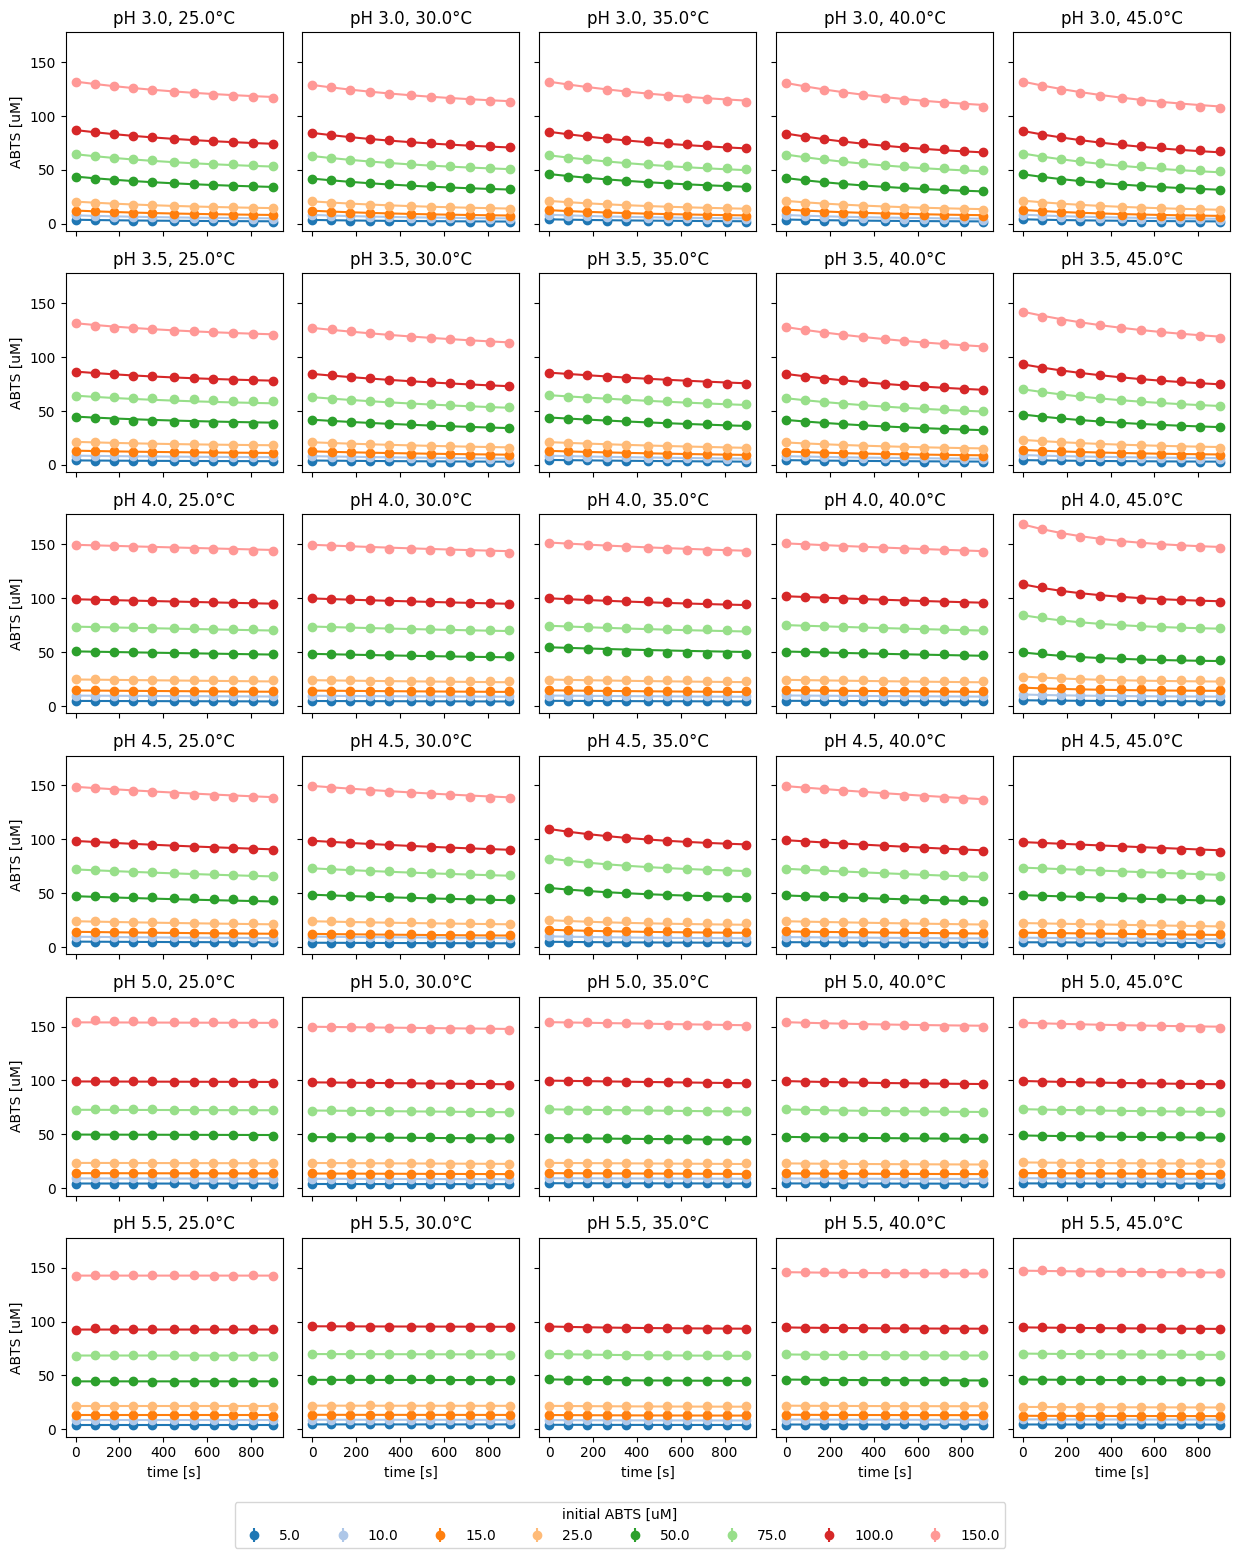

In [11]:

# Visualize all fitted models
fig, axes = plt.subplots(6,5, figsize=(12.5, 15), sharey=True, sharex=True)
for i, (doc, ax) in enumerate(zip(results, axes.flatten())):
    ph = doc.data.pH
    if not i%5:
        ax.set_ylabel("ABTS [uM]")
    doc.visualize(ax=ax, title = f"pH {doc.data.pH}, {doc.data.temperature}°C")
    if i in [25,26,27,28,29]:
        ax.set_xlabel("time [s]")
    if i == 0:
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(handles, labels, loc="lower center", ncol=len(labels), title="initial ABTS [uM]", bbox_to_anchor=(0.5,-0.04))
plt.tight_layout()

The above plot shows all kinetic experiments, fitted to the irreversible Michaelis-Menten model with time-dependent enzyme inactivation. Based on the reaction slopes, no catalytic avtivity is observable for reactions at pH 5 or higher.
In the following cells, the resulting kinetic parameters were extracted and visualized. As in the mass balance analysis, the reactions at pH 4, 45°C and pH 4.5, 35°C differ from other experiments of the respective pH. In both cases, every applied substrate concentration is higher than intended in the design of the experiment. Furthermore, the resulting parameter estimates have a high uncertanty. Therefore, the respective measurements are excluded from further analysis. Additionaly, the results from pH 5.5, 35°C were excluded, since the uncertainty of the parameters could not be estimated.

In [27]:
# Get kinetic parameters of all datasets
kcat = []
kcat_std = []
Km = []
Km_std = []
ki = []
ki_std = []
pH = []
temperature = []
corr_kcat_km = []
for result in results:
    params = result.get_parameter_dict()

    kcat.append(params["k_cat"].value)
    kcat_std.append(params["k_cat"].stderr)

    Km.append(params["Km"].value)
    Km_std.append(params["Km"].stderr)

    ki.append(params["K_ie"].value)
    ki_std.append(params["K_ie"].stderr)  

    correlation = params["k_cat"].correl
    if correlation == None:
        corr_kcat_km.append(float("nan"))
    else:
        corr_kcat_km.append(correlation["Km"])

    pH.append(result.data.pH)
    temperature.append(result.data.temperature)

df = pd.DataFrame.from_dict({
    'pH':pH, 
    "temperature [C]":temperature, 
    'kcat [1/s]':kcat, 
    'kcat stderr':kcat_std, 
    'Km [uM]':Km, 
    'Km stderr':Km_std, 
    "Enzyme inactivation [1/s]":ki,
    "Enzyme inactivation std":ki_std,
    "correlation kcat/Km":corr_kcat_km})

df["kcat/Km [1/s * uM]"] = df["kcat [1/s]"] / df["Km [uM]"]
kcat_km_stderr =((df["kcat stderr"]/df["kcat [1/s]"])**2+(df["Km stderr"]/df["Km [uM]"])**2)**0.5 * df["kcat/Km [1/s * uM]"]
df["kcat/Km stderr"] = kcat_km_stderr

df = df.drop(index=25) # reached parameter boundaries --> inactive
#df = df.drop(index=12) #Km really high stddev
df = df.drop(index=17) #kcat outlier
df = df.drop(index=14) #kcat outlier, mass balance outlier

df["zeros"] = np.zeros(27)

df


### Parameter estimates for $k_{cat}$ and $K_{m}$

corr

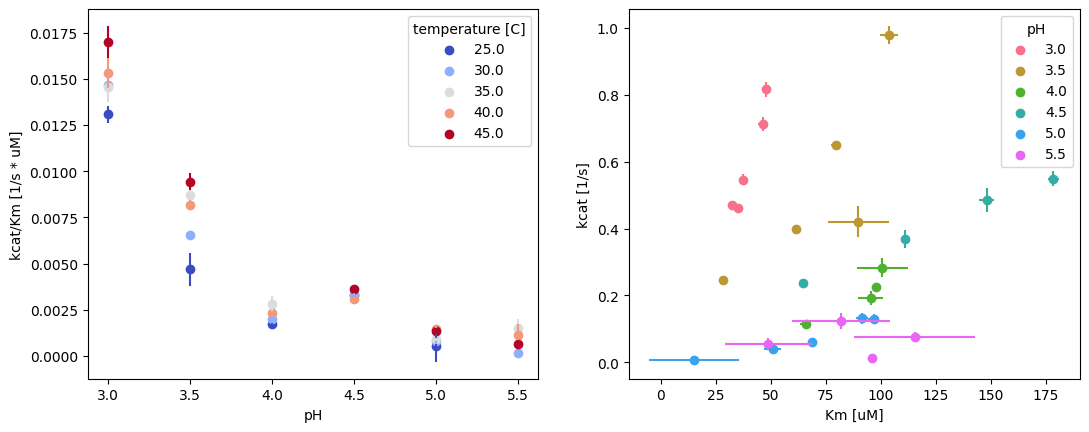

In [21]:
fig, axes = plt.subplots(1,2, figsize=(12.8, 4.8), sharey=False, sharex=False)
for i, ax in enumerate(axes.flatten()):
    if i==1:
        plot(df, xdata="Km [uM]", ydata="kcat [1/s]", xerror="Km stderr", yerror="kcat stderr", colors="pH", ax=ax)
    else:
        plot(df, xdata="pH", ydata="kcat/Km [1/s * uM]", xerror="zeros", yerror="kcat/Km stderr", colors="temperature [C]", ax=ax)
    

The figure on the left shows the catalytic efficiency $\frac{k_{cat}}{K_{m}}$ over the pH value of each reaction. The highest catalytic efficiency was observed at pH 3 and 45°C. Increasing the pH by 0.5 reduced $\frac{k_{cat}}{K_{m}}$ approximatel by half. For higher pH values, $\frac{k_{cat}}{K_{m}}$ is even more decreased. The catalytic efficiency is therefore highly sensitive to the pH. This might source from different causes. Eighter deprotonation ABTS sulfonate groups for more neutral pH values or protonation changes of the enzyme might hinder catalysis at higher pH values.  
In terms of temperature, higher $\frac{k_{cat}}{K_{m}}$ was achieved at higher temperatures. SLAC might even be more active at higher temperatures and pH values.

### Correlation between $k_{cat}$ and $K_{m}$

The parameter estimates for $k_{cat}$ and $K_{m}$ showed correlation. For experiments at pH 3 and pH 3.5, the parameters were correlated between 0.5 - 0.85. This indeicates, that the highest initial substrate concentration, which was applied for parameter estimation was not sufficently high. Ideally, the highest initial substrate concentration applied for a kinetic experiment should be 10-fold higher than $K_{m}$ to avoid correlation. In this scenario, only reactions with an initial substrate concentration of 150 uM were used for parameter estimation, due to the limited photometric measurement range of ABTS. Hence, ABTS was only applied 1.5-fold to 6-fold of the estimated $K_{m}$.  
For reactions at pH values of 4 and above, positive as well as negative correlations were observed. 
As the figure above on the right shows, $K_{m}$ was estimated in the range of 25 - 105 uM in the mentioned pH range. 
For reactions at higher pH values positive and negative correlations were observed.
Low and also negative correlations were observed for reactions with pH values at and above pH 4. 

The figure on the left shows $k_{cat}$ over $K_{m}$ for all experimental conditions, whereas the pH is color-coded. For reactions with identical pH values, $k_{cat}$ and $K_{m}$ both channge for different temperatures. This might also be attributed to the high correleation between the parameters. Thus, the true change of $k_{cat}$ or $K_{m}$ throu pH or temperature cannot be assessed.

For pH values of 5 and above, almost no catalytic activity was observed. Therefore, data of these experimental conditions is excluded from further analysis. 

### Time-dependent enzyme inactivation


- haflife
- plots
- correlation / causality

### Correlation analysis across all 



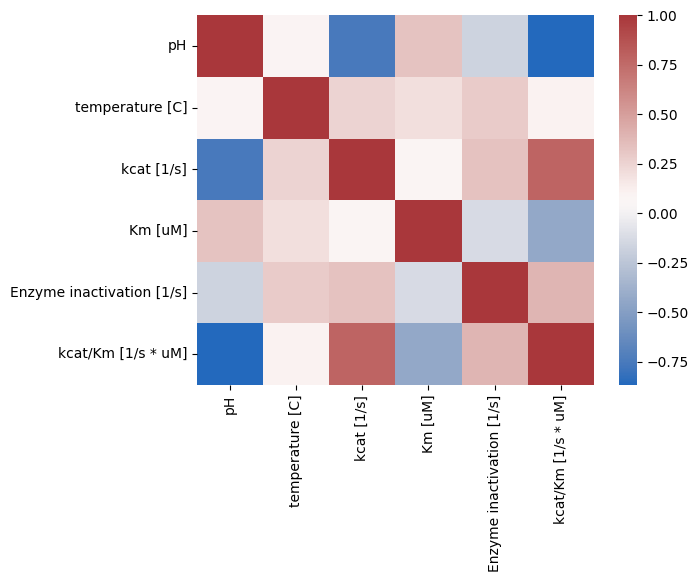

,pH,temperature [C],kcat [1/s],Km [uM],Enzyme inactivation [1/s],kcat/Km [1/s * uM]
pH,1.0***,0.03,-0.97**,0.63,-0.57,-0.99***
temperature [C],0.03,1.0***,0.08,0.04,0.14,0.03
kcat [1/s],-0.97**,0.08,1.0***,-0.47,0.52,0.94**
Km [uM],0.63,0.04,-0.47,1.0***,-0.68,-0.74
Enzyme inactivation [1/s],-0.57,0.14,0.52,-0.68,1.0***,0.66
kcat/Km [1/s * uM],-0.99***,0.03,0.94**,-0.74,0.66,1.0***


In [36]:
df_correlation = df.drop(columns=["kcat stderr", "Km stderr", "Enzyme inactivation std", "kcat stderr", "correlation kcat/Km", "kcat/Km stderr", "zeros"]).corr()

sns.heatmap(df_correlation, 
        xticklabels=df_correlation.columns,
        yticklabels=df_correlation.columns,
        cmap = sns.color_palette("vlag", as_cmap=True))
plt.show()

rho = df_correlation.corr()
pval = df_correlation.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

## Discussion

